In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:
import random
from IPython import get_ipython

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % (2**32 - 1)
    np.random.seed(worker_seed)

def pre_run_cell(_):
    set_seed(12)

ip = get_ipython()
ip.events.register('pre_run_cell', pre_run_cell)

## Dataset Introduction
This dataset contains two sets.

The first set is all goods, the second set contains goods and defective products.

You need to classify the products into defective ones or not, and calculate the accuracy.

The benchmark is accuracy.

In [15]:
BATCH_SIZE = 64
DATASET = 'cable'
LR = 1e-3
EPOCHS = 500
TMAX = 100
PTH_PATH = f'./data/pth/vae2_{DATASET}.pth'
LATENT_DIM = 128

In [16]:
import glob

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.image_paths = glob.glob(f"{root}/*.png")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = 0
        return img, label

train_dataset = CustomDataset(root=f'./data/train/{DATASET}', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=11)
val_dataset = CustomDataset(root=f'./data/val/{DATASET}', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=11)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset))

train:  179
val:  45


In [17]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


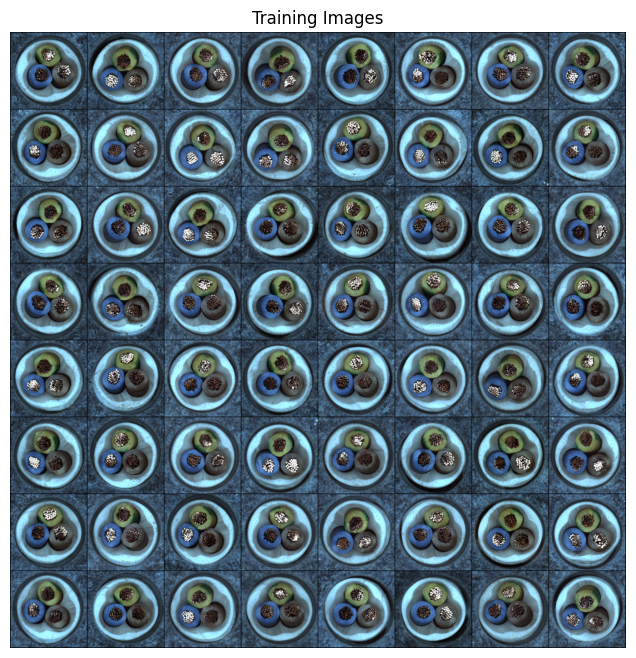

In [18]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [19]:
import torch
import torch.nn as nn
from torchvision import models

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * (image_size // 32) * (image_size // 32), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, latent_dim * 2)  # mu and logvar
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512 * (image_size // 32) * (image_size // 32)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (512, image_size // 32, image_size // 32)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [20]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [21]:
train_losses = []
val_losses = []

def train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    global train_losses, val_losses
    train_losses.clear()
    val_losses.clear()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            loss = loss_function(recon_x, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_x, mu, logvar = model(data)
                val_loss += loss_function(recon_x, data, mu, logvar).item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}.. Train Loss: {train_loss:.4f}.. Val Loss: {val_loss:.4f}")

In [22]:
model = VAE(LATENT_DIM).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TMAX, eta_min=1e-6)
total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters: {total_params}")
train_vae(model, train_loader, val_loader, optimizer, scheduler=scheduler, epochs=EPOCHS)

torch.save(model.state_dict(), PTH_PATH)

Epoch 1/500.. Train Loss: 59261401060033.3203.. Val Loss: 3424206.2222
Epoch 2/500.. Train Loss: 28334669183.2849.. Val Loss: 5603379.2000
Epoch 3/500.. Train Loss: 25621920.5810.. Val Loss: 101125.9111
Epoch 4/500.. Train Loss: 153428.2318.. Val Loss: 54792.6111
Epoch 5/500.. Train Loss: 69702.3617.. Val Loss: 42054.8500
Epoch 6/500.. Train Loss: 49266.3911.. Val Loss: 37803.0056
Epoch 7/500.. Train Loss: 39870.4546.. Val Loss: 36055.0139
Epoch 8/500.. Train Loss: 35271.1383.. Val Loss: 34786.3028
Epoch 9/500.. Train Loss: 28593.3024.. Val Loss: 35644.0944
Epoch 10/500.. Train Loss: 40238.3764.. Val Loss: 37613.4889
Epoch 11/500.. Train Loss: 29628.6459.. Val Loss: 37344.8389
Epoch 12/500.. Train Loss: 27692.5426.. Val Loss: 36552.8583
Epoch 13/500.. Train Loss: 24172.7332.. Val Loss: 35858.9306
Epoch 14/500.. Train Loss: 21997.7591.. Val Loss: 34971.0000
Epoch 15/500.. Train Loss: 20309.8436.. Val Loss: 34417.7972
Epoch 16/500.. Train Loss: 19394.9584.. Val Loss: 34230.5556
Epoch 17/

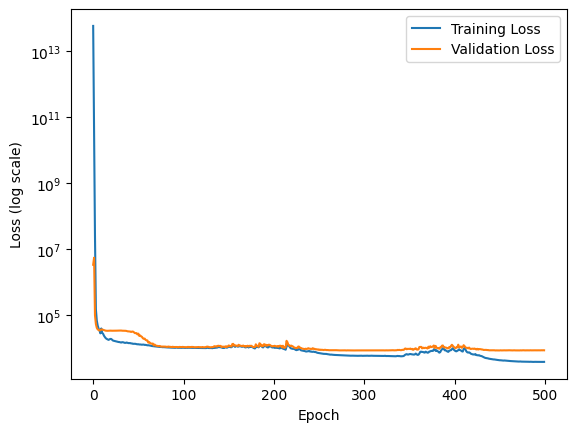

In [38]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
# plt.ylim(3e3, 1e5)
plt.yscale('log')
plt.legend()

## Calculate the reconstruction loss
The reconstruction loss between good products and defective products should have difference.

You can use the following codes to evaluate the reconstruction loss, and find something useful information.

/tmp/ipykernel_1499338/1488696479.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PTH_PATH))


good avg:  8494.131962217134
defective avg:  11742.734019403872


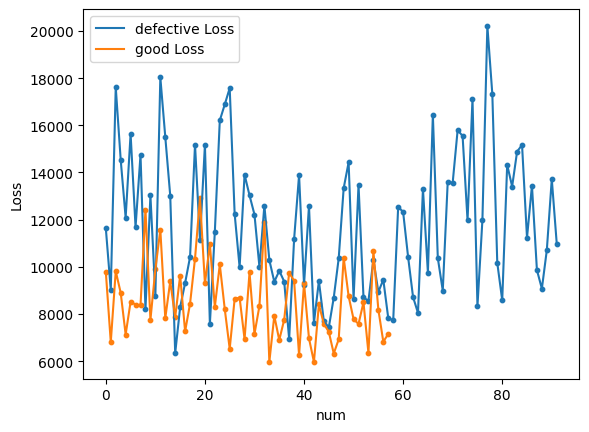

In [24]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

images = []

model = VAE(LATENT_DIM).to(device)
model.load_state_dict(torch.load(PTH_PATH))

def test(image_path, vae, device):
    img = Image.open(image_path)
    img = transform(img).to(device)
    img = img.unsqueeze(0)

    vae.eval()
    with torch.no_grad():
        recon, mu, log_var = vae(img)
        images.append((img, recon))
        test_loss = loss_function(recon, img, mu, log_var)
        return test_loss.item()

testimg_dir = f'./data/test/{DATASET}/good'
testimg_dir2 = f'./data/test/{DATASET}/error'

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

## Calculate Accuracy
You need to calculate the accuracy of products' predictions. 

A easy way is to use the reconstruction loss to distinguish between goods and defective ones.

It is not restricted to use this way, you also can use another methods and write they into report.

In [25]:
from sklearn.metrics import f1_score

def calculate_accuracy_and_f1(threshold=100.0):
    set_seed(42)
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    # Good products (正類)
    for img_file in os.listdir(testimg_dir):
        img_path = os.path.join(testimg_dir, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            true_labels.append(1)  # 正類標籤
            if loss < threshold:
                predicted_labels.append(1)  # 預測正類
                correct += 1
            else:
                predicted_labels.append(0)  # 預測負類
            total += 1

    # Defective products (負類)
    for img_file in os.listdir(testimg_dir2):
        img_path = os.path.join(testimg_dir2, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            true_labels.append(0)  # 負類標籤
            if loss >= threshold:
                predicted_labels.append(0)  # 預測負類
                correct += 1
            else:
                predicted_labels.append(1)  # 預測正類
            total += 1

    accuracy = correct / total * 100

    # 計算 F1-score
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, f1


def find_best_threshold(low=0, high=2000, tolerance=1):
    """
    使用三分搜尋找到最佳的 threshold。
    """
    set_seed(42)
    best_threshold = 0
    best_accuracy = 0

    while high - low > tolerance:
        # 計算兩個中點
        mid1 = low + (high - low) // 3
        mid2 = high - (high - low) // 3

        # 計算兩個中點的準確率
        accuracy1, f11 = calculate_accuracy_and_f1(mid1)
        accuracy2, f12 = calculate_accuracy_and_f1(mid2)

        print(accuracy1, f11, mid1, accuracy2, f12, mid2)

        # 比較兩個中點的準確率
        if accuracy1 > accuracy2:
            if accuracy1 > best_accuracy:
                best_accuracy = accuracy1
                best_threshold = mid1
            high = mid2 - 1
        elif accuracy1 == accuracy2:
            if accuracy1 > best_accuracy:
                best_accuracy = accuracy1
                best_threshold = mid1
            if f11 > f12:
                high = mid2 - 1
            else:
                low = mid1 + 1
        else:
            if accuracy2 > best_accuracy:
                best_accuracy = accuracy2
                best_threshold = mid2
            low = mid1 + 1

    return best_threshold, best_accuracy

In [26]:
find_best_threshold(1000, 20000)

68.66666666666667 0.3561643835616438 7333 56.00000000000001 0.6373626373626373 13667
61.33333333333333 0.0 5222 72.66666666666667 0.6771653543307087 9444
70.66666666666667 0.5217391304347826 8037 68.66666666666667 0.6928104575163399 10852
66.66666666666666 0.2857142857142857 7099 74.66666666666667 0.6724137931034483 8975
74.0 0.6138613861386139 8350 72.0 0.6818181818181818 9601
72.0 0.5227272727272727 7933 76.0 0.6727272727272727 8767
74.66666666666667 0.6346153846153846 8489 73.33333333333333 0.6610169491525424 9045
74.0 0.6138613861386139 8304 74.66666666666667 0.6481481481481481 8674
75.33333333333333 0.6476190476190476 8551 76.0 0.6727272727272727 8798
75.33333333333333 0.6605504587155964 8716 75.33333333333333 0.6666666666666666 8880
76.0 0.6727272727272727 8826 74.66666666666667 0.6724137931034483 8935
76.0 0.6727272727272727 8789 76.0 0.6727272727272727 8862
76.0 0.6727272727272727 8838 75.33333333333333 0.6666666666666666 8886
76.0 0.6727272727272727 8821 76.0 0.672727272727272

(8767, 76.0)